# Tutorial III: Dimensionality Reduction and Clustering
###Acknowledgment
1.   This tutorial was prepared by Najee Stubbs at the University of Arkansas (nistubbs@uark.edu) and revised following comments from Mehdi Vahab (mvahab@mathworks.com).
2.   The development of this tutorial was supported by a gift from MathWorks through the MathWorks Curriculum Development Support program.
3.   The dataset and algorithms used in this tutorial are from C. Dunlap, H. Pandey, and H. Hu, “Supervised and Unsupervised Learning Models for Detection of Critical Heat Flux During Pool Boiling,” in Proceedings of the ASME 2022 heat Transfer Summer Conference, HT2022-85582. [[link](https://asmedigitalcollection.asme.org/HT/proceedings/HT2022/85796/V001T08A004/1146566)]
4.   This tutorial was implemented in MEEG tech elective "Machine Learning for Mechanical Engineers." [[link](https://ned3.uark.edu/teaching/)]

### Procedure
In this tutorial, we will use PCA to reduce the dimensionality of two classes of images and then use K-means clustering to group the images into similar clusters. The following steps will be followed:

In this tutorial, we will walk through the steps to analyze an image dataset using dimensionality reduction and clustering techniques. The code provided focuses on two main procedures: Principal Component Analysis (PCA) and K-means clustering. The tutorial will cover the following steps:
1. Import and process the image dataset: Import images from two classes: pre-CHF and post-CHF. Resize the images to a specific size. Store the images and corresponding labels in separate arrays.
2. Perform Principal Component Analysis (PCA): Apply PCA on the preprocessed images. Obtain the principal component coefficients, scores, and explained variance. Plot the cumulative explained variance to determine the optimal number of principal components.
3. Perform and evaluate K-means clustering: Use K-means clustering on the PCA scores with varying numbers of principal components. Assess the quality of clustering using evaluation metrics, including clustering accuracy, average silhouette coefficient, and Davies-Bouldin index. Visualize the clustering results by creating scatter plots and a confusion matrix.
4. Perform image reconstruction using PCA: Select a representative image from the post-CHF class. Perform image reconstruction using different numbers of principal components. Measure the reconstruction error (RMSE) by comparing the reconstructed images to the original image. Plot the reconstructed images and the corresponding RMSE as a function of the number of principal components.

### 1. Load Libraries

In [ ]:
import glob
import os
import cv2
import numpy as np
import pandas as pd
from time import time
from PIL import Image
from mpl_toolkits import mplot3d

import plotly as py
import plotly.graph_objs as go
import plotly.express as ps

from matplotlib import pyplot as plt
from matplotlib.pyplot import imread

from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tqdm.notebook import tqdm

# For use with google collab
from google.colab import drive

### 2. Import & Process Dataset

In [ ]:
drive.mount('/content/drive')

In [ ]:
'''
This section of code processes an image dataset containing two categories: 'pre-CHF' and 'post-CHF'.
The dataset is stored in a directory named 'ImageDataset' located in Google Colab's default drive path.
The code performs the following steps:
1. Reads and lists all the image files from the 'pre-CHF' and 'post-CHF' directories.
2. Initializes lists to store the images and their corresponding labels.
3. Reads each image file, resizes it to a uniform size, and appends it to the appropriate list.
The labels (0 for 'pre-CHF' and 1 for 'post-CHF') are also appended to their respective lists.
4. After processing all images, the code concatenates the images and labels of both categories.
5. The images are then flattened to make them suitable for machine learning models.
6. Finally, the code prints the sizes of the processed datasets for verification.
'''

# Define the root directory where the image dataset is located.
data_root = '/content/drive/MyDrive/Colab Notebooks/ImageDataset'

# Use glob to get the list of all 'pre-CHF' and 'post-CHF' image files from the provided directory
preCHF_dir = glob.glob(os.path.join(data_root, 'pre-CHF/*.jpg'))
postCHF_dir = glob.glob(os.path.join(data_root, 'post-CHF/*.jpg'))

# Initialize lists to store images and their corresponding labels
preCHF_images, postCHF_images = [], []
preCHF_labels, postCHF_labels = [], []

# Loop through each pair of 'pre-CHF' and 'post-CHF' image files
for i, (preCHF_file, postCHF_file) in tqdm(enumerate(zip(preCHF_dir, postCHF_dir)), total=max(len(preCHF_dir), len(postCHF_dir))):
    # Read, resize and store the 'pre-CHF' image and its label
    read_file = cv2.imread(preCHF_file, cv2.IMREAD_GRAYSCALE)
    resized_file = cv2.resize(read_file, (128, 80))
    preCHF_images.append(resized_file)
    preCHF_labels.append(0)  # Label for 'pre-CHF' is 0

    # Read, resize and store the 'post-CHF' image and its label
    read_file = cv2.imread(postCHF_file, cv2.IMREAD_GRAYSCALE)
    resized_file = cv2.resize(read_file, (128, 80))
    postCHF_images.append(resized_file)
    postCHF_labels.append(1)  # Label for 'post-CHF' is 1

# Concatenate the images and labels of both categories to create a single dataset
labels = np.concatenate((preCHF_labels, postCHF_labels), axis=0)
images = np.concatenate((preCHF_images, postCHF_images), axis=0)

# Flatten the images to make them suitable for machine learning models
flattened_images = images.reshape(images.shape[0], -1)

# Print the shapes of the processed datasets for verification
print('Size of the pre-CHF images:', np.array(preCHF_images).shape)
print('Size of the pre-CHF labels:', np.array(preCHF_labels).shape)
print('Size of the post-CHF images:', np.array(postCHF_images).shape)
print('Size of the post-CHF labels:', np.array(postCHF_labels).shape)
print('Size of the concatenated labels:', labels.shape)
print('Size of the concatenated images:', images.shape)
print('Size of the flattened images:', flattened_images.shape)

  0%|          | 0/1500 [00:00<?, ?it/s]

Size of the pre-CHF images: (1500, 80, 128)
Size of the pre-CHF labels: (1500,)
Size of the post-CHF images: (1500, 80, 128)
Size of the post-CHF labels: (1500,)
Size of the concatenated labels: (3000,)
Size of the concatenated images: (3000, 80, 128)
Size of the flattened images: (3000, 10240)


### 3. Perform Principal Component Analysis

Number of components before PCA =10240
Number of components for PCA 95% Explained =745
Time for PCA Analysis = 49.121795415878296
Dimension of data after PCA =(3000, 745)


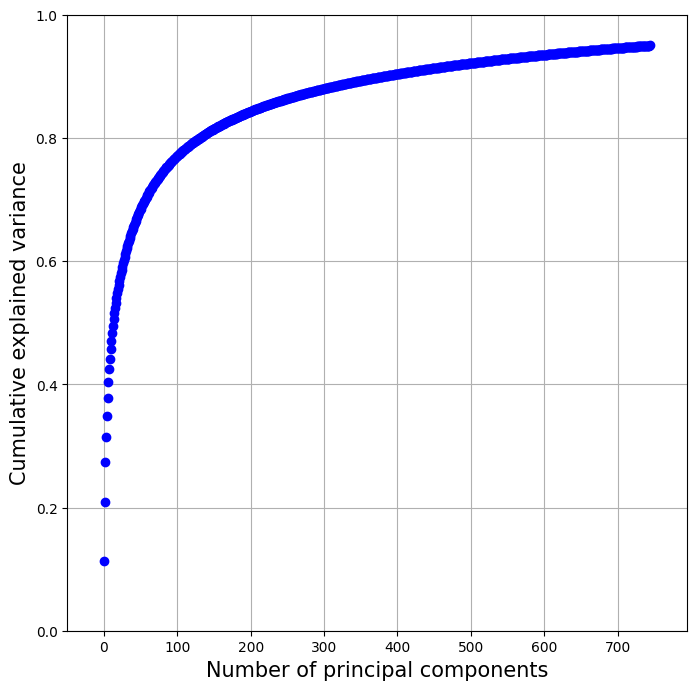

In [ ]:
'''
This section of the code performs Principal Component Analysis (PCA) on a dataset of flattened images. The aim is to reduce the
dimensionality of the data while retaining 95% of the variance. The number of principal components required to achieve this
explained variance is determined. The code also measures and prints the time taken for the PCA analysis. Finally, it visualizes
the cumulative explained variance against the number of principal components using a plot.
'''
# Record the start time for PCA analysis
start = time()

# Specify the desired variance to retain
variance = 0.95
# Initialize PCA with the desired variance
pca = PCA(variance)
# Fit the PCA model to the flattened images
pca.fit(flattened_images)

# Record the end time for PCA analysis
end = time()

# Transform the original data into the reduced dimensionality space using the trained PCA model
reduced_data = pca.transform(flattened_images)

# Print the number of features before and after PCA, and the time taken for the PCA analysis
print('Number of components before PCA =' + str (flattened_images.shape[1]))
print('Number of components for PCA 95% Explained =' + str (pca.n_components_))
print('Time for PCA Analysis = ' + str(end - start))
print('Dimension of data after PCA =' + str(reduced_data.shape))

# Plotting the cumulative explained variance against the number of principal components
plt.figure(figsize=[8,8]);
plt.rcParams['font.size']='10'
# Plot the cumulative explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_),'bo');
plt.xlabel('Number of principal components',fontsize=15);
plt.ylabel('Cumulative explained variance', fontsize=15);
plt.grid();
# Setting the limits for the x-axis and y-axis
plt.xlim(-50, pca.n_components_+ 50);
plt.ylim(0,1);

### 4. Perform K-Means Clustering & Evaluate Clustering

Size of the Normalized Reduced-Data (Normalized After PCA): (3000, 745)


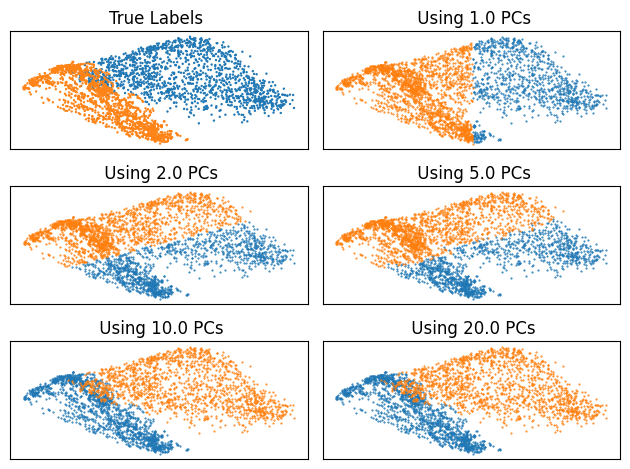

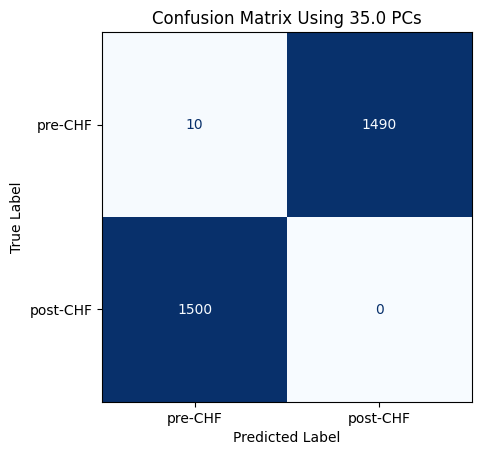

  Cluster Set   Number of PCs  Clustering Accuracy  Silhouette Coeff  Davies Bouldin Index
 Cluster Set 1            1.0             0.573333          0.582691              0.559779
 Cluster Set 2            2.0             0.066667          0.390136              1.124640
 Cluster Set 3            3.0             0.072667          0.289710              1.484077
 Cluster Set 4            4.0             0.041333          0.253248              1.659143
 Cluster Set 5            5.0             0.032667          0.228347              1.777281
 Cluster Set 6            6.0             0.028667          0.211743              1.880141
 Cluster Set 7            7.0             0.978000          0.212942              1.972572
 Cluster Set 8            8.0             0.979333          0.204827              2.020478
 Cluster Set 9            9.0             0.989333          0.198968              2.065284
Cluster Set 10           10.0             0.990000          0.192088              2.108790

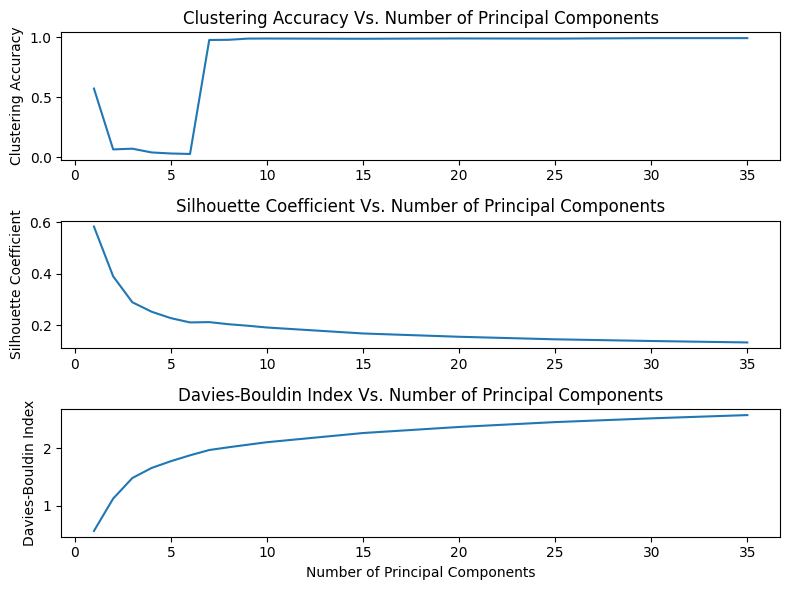

In [ ]:
'''
Description:
The code aims to perform k-means clustering on a dataset that has undergone PCA (Principal Component Analysis) and normalization.
It evaluates the effect of different numbers of principal components (PCs) on clustering accuracy and other metrics.
The code visualizes the clusters for certain numbers of PCs, displays the confusion matrix for the clustering results
against the true labels, and plots the clustering accuracy, silhouette coefficient, and Davies-Bouldin Index
against the number of PCs used.
'''

# Normalize the reduced data obtained after PCA
normalized_reduced_data = normalize(reduced_data)
print('Size of the Normalized Reduced-Data (Normalized After PCA):', normalized_reduced_data.shape)

# Define different numbers of principal components to be considered for clustering
N = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35]
iters_to_plot = [N.index(n) for n in [1, 2, 5, 10, 20]]

# Initialize arrays to store clustering metrics
num_pcs_used = np.zeros(len(N))
clustering_accuracy = np.zeros(len(N))
davies_bouldin_index = np.zeros(len(N))
avg_silhouette_coeffs = np.zeros(len(N))
cluster_sets = ['Cluster Set ' + str(i) for i in range(1, len(N) + 1)]

# Plot the true labels of the data
fig, axes = plt.subplots(3, 2)
ax = axes[0, 0]
colormap=np.array(['#1F77B4','#FF8418'])
ax.scatter(normalized_reduced_data[:, 0], normalized_reduced_data[:, 1], s=0.5, c=colormap[labels])
ax.set_title('True Labels ')
ax.set_xticks([])
ax.set_yticks([])
plt.grid(False)

# Initialize k-means clustering
kmeans = KMeans(init='random', n_clusters=2, n_init=10, max_iter=300, random_state=42)

# Perform k-means clustering for different numbers of principal components and compute clustering metrics
for i in range(len(N)):
    kmeans.fit(normalized_reduced_data[:, :N[i]])
    centers = kmeans.cluster_centers_
    idx = kmeans.labels_

    num_pcs_used[i] = N[i]
    cluster_sets[i] = 'Cluster Set ' + str(i+1)

    C = confusion_matrix(labels, idx)
    clustering_accuracy[i] = np.abs(accuracy_score(labels, idx) - 0.5) / 0.5
    davies_bouldin_index[i] = davies_bouldin_score(normalized_reduced_data[:, :N[i]], idx)
    avg_silhouette_coeffs[i] = np.mean(silhouette_score(normalized_reduced_data[:, :N[i]], idx))

    # Plot the clustering results for certain numbers of principal components
    if i in iters_to_plot:
        ax = axes[divmod(iters_to_plot.index(i)+1, 2)]
        ax.scatter(normalized_reduced_data[idx == 0, 0], normalized_reduced_data[idx == 0, 1], s=1, marker='.')
        ax.scatter(normalized_reduced_data[idx == 1, 0], normalized_reduced_data[idx == 1, 1], s=1, marker='.')

        ax.set_title( ' Using ' + str(num_pcs_used[i]) + ' PCs')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)

plt.tight_layout()
plt.show()

# Display the confusion matrix for the clustering results
cm = ConfusionMatrixDisplay(confusion_matrix=C)
cm.plot(cmap=plt.cm.Blues, colorbar=False)
plt.title('Confusion Matrix Using ' + str(num_pcs_used[i]) + ' PCs')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=[0, 1], labels=['pre-CHF', 'post-CHF'])
plt.yticks(ticks=[0, 1], labels=['pre-CHF', 'post-CHF'])
plt.grid(False)
plt.show()

# Print a table summarizing the clustering metrics for different numbers of principal components
T = pd.DataFrame({
    'Cluster Set ': cluster_sets,
    'Number of PCs': num_pcs_used,
    'Clustering Accuracy': clustering_accuracy,
    'Silhouette Coeff': avg_silhouette_coeffs,
    'Davies Bouldin Index': davies_bouldin_index})

print(T.to_string(index=False))

# Plot the clustering metrics against the number of principal components used
fig = plt.figure(figsize=(8, 6))

plt.subplot(3, 1, 1)
plt.plot(num_pcs_used, clustering_accuracy)
plt.ylabel('Clustering Accuracy')
plt.title('Clustering Accuracy Vs. Number of Principal Components')

plt.subplot(3, 1, 2)
plt.plot(num_pcs_used, avg_silhouette_coeffs)
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Coefficient Vs. Number of Principal Components')

plt.subplot(3, 1, 3)
plt.plot(num_pcs_used, davies_bouldin_index)
plt.xlabel('Number of Principal Components')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index Vs. Number of Principal Components')

plt.tight_layout()
plt.show()

### 5. Perform Image Reconstruction

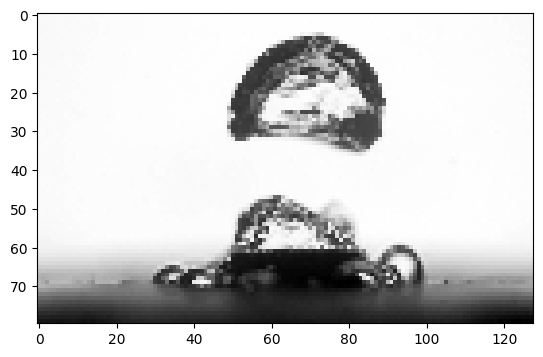

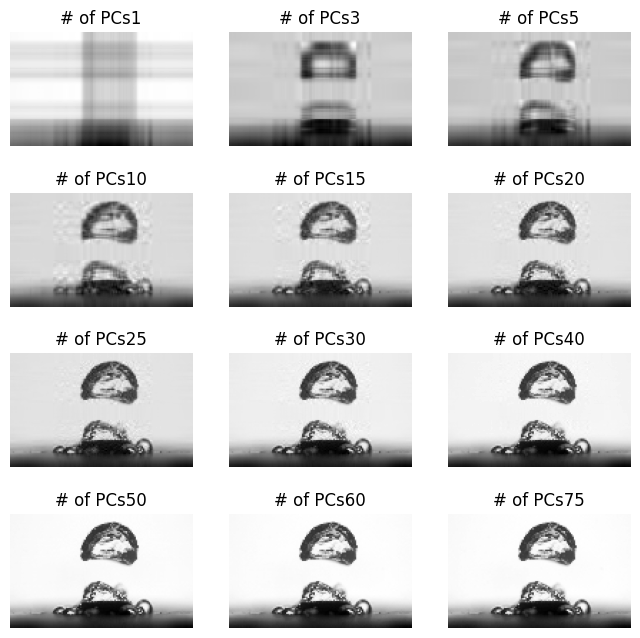

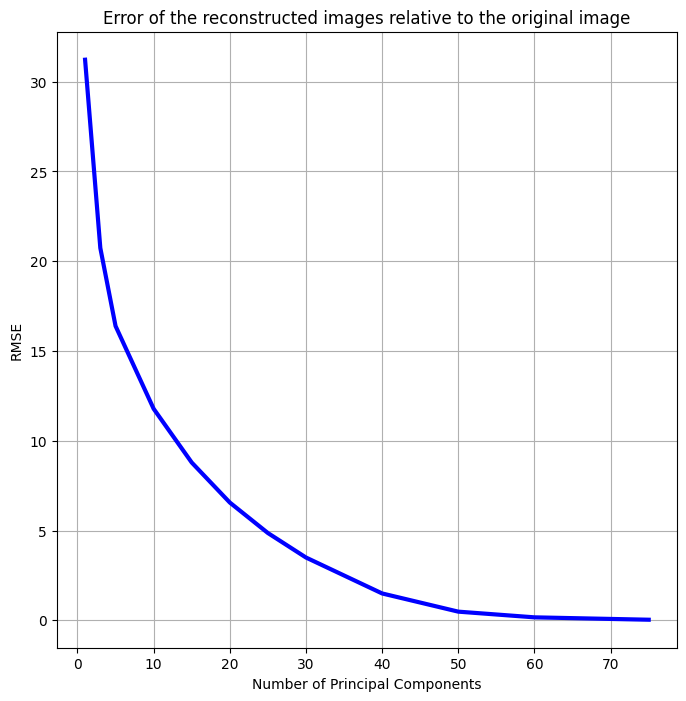

In [ ]:
'''
This section aims to demonstrate the effect of applying Principal Component Analysis (PCA) on a representative image from the 'post-CHF'
category, using different numbers of principal components (PCs). First, it displays the original image. Then, PCA is applied to the
image with varying numbers of PCs, and the reconstructed images are displayed side by side for comparison. Additionally, the Root Mean
Square Error (RMSE) between the original and each reconstructed image is computed to quantify the reconstruction error. Finally,
a plot is generated to visualize the relationship between the number of PCs used and the resulting RMSE.
'''

# Select a representative image from the 'post-CHF' category for demonstration
rep_image = postCHF_images[500]
plt.imshow(rep_image,cmap = plt.cm.gray);

# Define the PCA function to perform PCA on the image and reconstruct it using 'k' principal components
def PCA(k):
    pca = IncrementalPCA(n_components=k)
    reconstructed_image = pca.inverse_transform(pca.fit_transform(rep_image))
    return reconstructed_image

# Define a function to compute the Root Mean Square Error (RMSE) between two images
def rmse(imageA,imageB):
    error = np.sum((imageA.flatten() - imageB.flatten())**2)
    error /= float(imageA.shape[0] * imageA.shape[1])
    return error**0.5

# List of different numbers of principal components to be used for PCA
k = [1, 3, 5, 10, 15, 20, 25, 30, 40, 50, 60, 75];

# Initialize a list to store RMSE values for each reconstructed image
error_images = []

# Set up a plot to display the original and reconstructed images side by side
plt.figure(figsize=(8,8))
for i in range(0,len(k)):
    # Reconstruct the image using 'k[i]' principal components
    reconstructed_image = PCA(k[i])
    # Compute the RMSE between the original and reconstructed image
    error = rmse(rep_image, reconstructed_image)
    error_images.append(error)

    # Display the reconstructed image
    ax = plt.subplot(4,3,i+1)
    plt.imshow(reconstructed_image,cmap = plt.cm.gray)
    plt.title("# of PCs"+str(k[i]))
    plt.axis('off')
plt.show()

# Plot the RMSE values for each number of principal components used
plt.figure(figsize=(8,8))
plt.title('Error of the reconstructed images relative to the original image')
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.plot(k,error_images,'b-',linewidth=3)
plt.grid()
plt.show;